In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import Dense
from scipy.interpolate import interp1d
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Dropout

# I. Data Loading

In [3]:
# Loading the Monthly Solar Data
file_path = 'solar_data.xlsx'
sheet_name = 'solarbymonth'

# Read the Excel sheet into a Pandas DataFrame
monthly_data = pd.read_excel(file_path, sheet_name=sheet_name)

# Extract relevant columns
monthly_data['Month'] = pd.to_datetime(monthly_data['Month'])  # Ensure the 'Month' column is in datetime format
months = monthly_data['Month']
utility_gen = monthly_data['Utility Scale Generation']
small_scale_gen = monthly_data['Small Scale Generation']
total_solar = monthly_data['Total Solar']

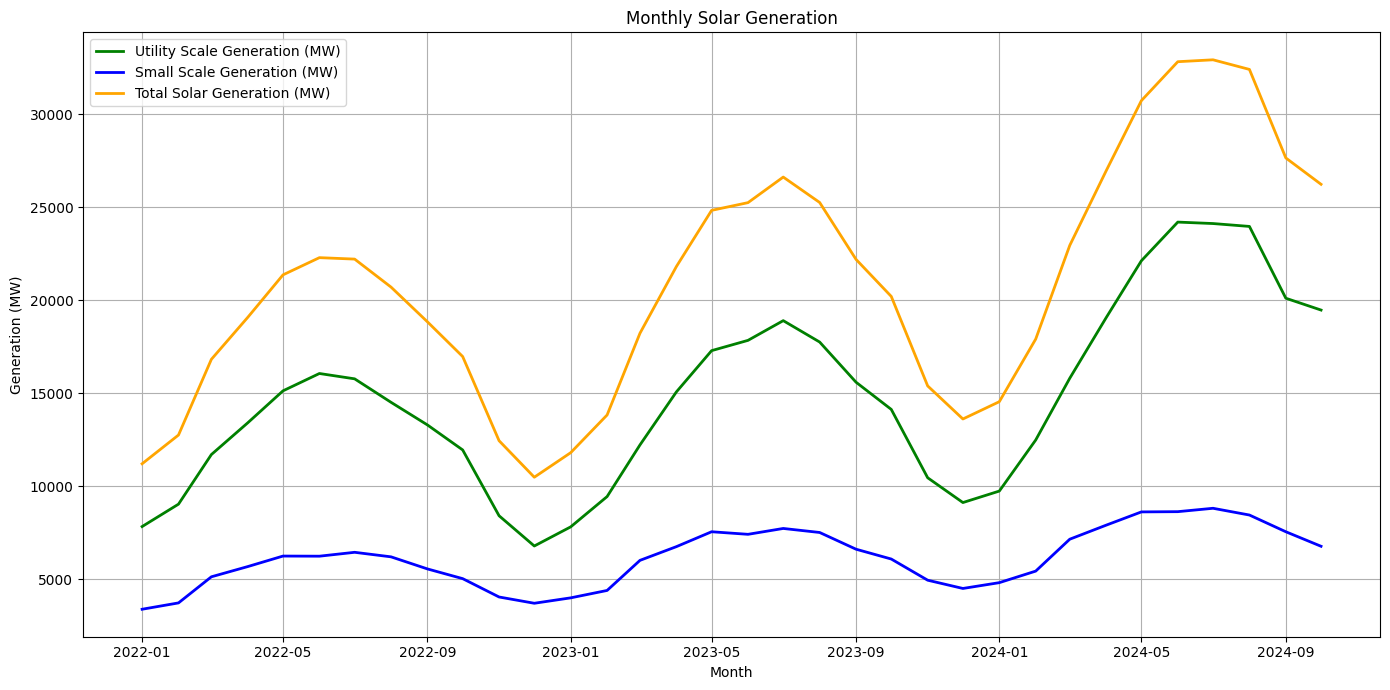

In [4]:
# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(months, utility_gen, label='Utility Scale Generation (MW)', color='green', linewidth=2)
plt.plot(months, small_scale_gen, label='Small Scale Generation (MW)', color='blue', linewidth=2)
plt.plot(months, total_solar, label='Total Solar Generation (MW)', color='orange', linewidth=2)
plt.xlabel('Month')
plt.ylabel('Generation (MW)')
plt.title('Monthly Solar Generation')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [5]:
# Loading the TSI Data
data_dir = 'tsi_monthly'

# Find all NetCDF files in the directory
file_paths = sorted(glob(os.path.join(data_dir, 'tsi_*.nc')))

# Initialize an empty list to store DataFrames
data_frames = []

# Loop through each file and load the data
for file_path in file_paths:
    # Open the NetCDF file
    dataset = xr.open_dataset(file_path)
    
    # Convert the dataset to a Pandas DataFrame and reset the index
    df = dataset.to_dataframe().reset_index()
    
    # Ensure the 'time' column is in datetime format
    df['time'] = pd.to_datetime(df['time'])
    
    # Append the DataFrame to the list
    data_frames.append(df)

all_data = pd.concat(data_frames, ignore_index=True)

# Verify loading
print(all_data.head())

        time  bounds          TSI   TSI_UNC  time_bnds
0 2014-01-15       0  1361.692383  0.152830 2014-01-01
1 2014-01-15       1  1361.692383  0.152830 2014-02-01
2 2014-02-15       0  1361.590088  0.173391 2014-02-01
3 2014-02-15       1  1361.590088  0.173391 2014-03-01
4 2014-03-15       0  1362.293213  0.133309 2014-03-01


In [6]:
# Loading the Exponential Regression Data

def exp_func(x, a, b):
    return a * np.exp(b * x)

file_path = 'solar_data.xlsx'
sheet_name = 'capacitygrowth'

# Read the Excel sheet into a Pandas DataFrame
solar_data = pd.read_excel(file_path, sheet_name=sheet_name)

# Sum the residential and commercial annual capacities into small scale
solar_data['Small Scale Annual'] = solar_data['Residential Annual'] + solar_data['Commercial Annual']
solar_data['Small Scale Cumul'] = solar_data['Residential Cumul'] + solar_data['Commercial Cumul']

# Extract relevant columns
years = solar_data['Year']
small_scale_annual = solar_data['Small Scale Annual']
utility_annual = solar_data['Utility Annual']
small_scale_cumul = solar_data['Small Scale Cumul']
utility_cumul = solar_data['Utility Cumul']

# Normalize the years to start from 0 for better numerical stability
normalized_years = years - years.min()

# Perform regression for small scale
params_small, _ = curve_fit(exp_func, normalized_years, small_scale_cumul, maxfev=10000)
small_scale_pred = exp_func(normalized_years, *params_small)

# Perform regression for utility
params_utility, _ = curve_fit(exp_func, normalized_years, utility_cumul, maxfev=10000)
utility_pred = exp_func(normalized_years, *params_utility)

# Verify loading
print(params_small)
print(params_utility)

[2.38570266e+03 2.05533322e-01]
[3.00547527e+03 2.30188812e-01]


# I. TLNN Preliminary Testing

In [7]:
# Generate lagged features for TLNN
def create_lagged_features(data, lag, period):
    X, y = [], []
    for i in range(len(data) - lag * period):
        X.append([data[i + (j * period)] for j in range(lag)])
        y.append(data[i + lag * period])
    return np.array(X), np.array(y)

In [8]:
lag = 12  # Seasonal period
utility_gen_values = utility_gen.values  # Ensure the data is in numpy array format

# Create lagged features
X_lagged, y_lagged = create_lagged_features(utility_gen_values, lag=1, period=lag)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_lagged, y_lagged, test_size=0.2, random_state=42)

In [9]:
# Feature scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train.reshape(-1, 1))
y_test = sc_y.transform(y_test.reshape(-1, 1))

In [10]:
# Define the TLNN model
def create_tlnn(n_layers, n_activation, kernels):
    model = tf.keras.models.Sequential()
    for i, nodes in enumerate(n_layers):
        if i == 0:
            model.add(Dense(nodes, activation=n_activation, kernel_initializer=kernels, input_dim=X_train.shape[1]))
        else:
            model.add(Dense(nodes, activation=n_activation, kernel_initializer=kernels))
    model.add(Dense(1))  # Output layer
    model.compile(loss='mse', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [11]:
# Create and summarize the model
tlnn = create_tlnn([32, 64], 'relu', 'normal')
tlnn.summary()

C:\Users\brayk\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the model
history = tlnn.fit(X_train, y_train, batch_size=32, epochs=150, validation_data=(X_test, y_test), verbose=2)

Epoch 1/150
1/1 - 1s - 1s/step - loss: 0.9896 - root_mean_squared_error: 0.9948 - val_loss: 1.5010 - val_root_mean_squared_error: 1.2252
Epoch 2/150
1/1 - 0s - 58ms/step - loss: 0.9788 - root_mean_squared_error: 0.9894 - val_loss: 1.4886 - val_root_mean_squared_error: 1.2201
Epoch 3/150
1/1 - 0s - 53ms/step - loss: 0.9688 - root_mean_squared_error: 0.9843 - val_loss: 1.4749 - val_root_mean_squared_error: 1.2145
Epoch 4/150
1/1 - 0s - 70ms/step - loss: 0.9595 - root_mean_squared_error: 0.9796 - val_loss: 1.4614 - val_root_mean_squared_error: 1.2089
Epoch 5/150
1/1 - 0s - 63ms/step - loss: 0.9506 - root_mean_squared_error: 0.9750 - val_loss: 1.4476 - val_root_mean_squared_error: 1.2032
Epoch 6/150
1/1 - 0s - 61ms/step - loss: 0.9420 - root_mean_squared_error: 0.9706 - val_loss: 1.4342 - val_root_mean_squared_error: 1.1976
Epoch 7/150
1/1 - 0s - 70ms/step - loss: 0.9333 - root_mean_squared_error: 0.9661 - val_loss: 1.4212 - val_root_mean_squared_error: 1.1922
Epoch 8/150
1/1 - 0s - 56ms/s

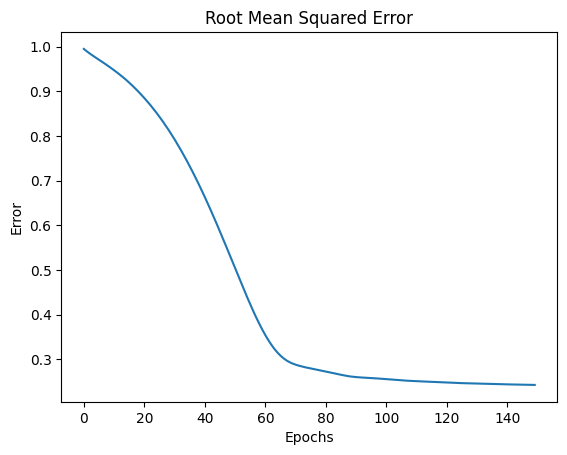

In [13]:
# Plot RMSE over epochs
plt.plot(history.history['root_mean_squared_error'])
plt.title('Root Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()

In [14]:
# Evaluate the model
train_rmse = tlnn.evaluate(X_train, y_train, verbose=0)
test_rmse = tlnn.evaluate(X_test, y_test, verbose=0)
print("Train RMSE:", train_rmse[1])
print("Test RMSE:", test_rmse[1])

Train RMSE: 0.24285666644573212
Test RMSE: 0.27352046966552734


In [15]:
# Predictions and inverse transformation
y_pred = tlnn.predict(X_test)
y_pred_orig = sc_y.inverse_transform(y_pred)
y_test_orig = sc_y.inverse_transform(y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


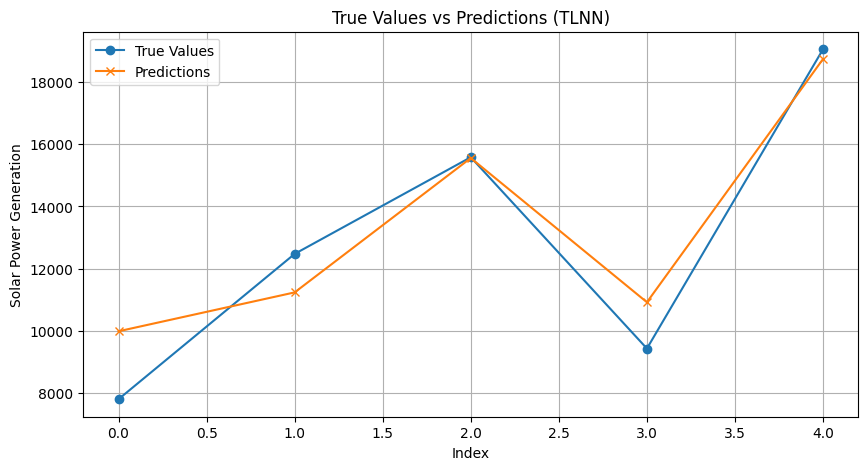

In [16]:
# Visualization: Predictions vs Real Values
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test_orig)), y_test_orig, label='True Values', marker='o')
plt.plot(range(len(y_pred_orig)), y_pred_orig, label='Predictions', marker='x')
plt.xlabel('Index')
plt.ylabel('Solar Power Generation')
plt.title('True Values vs Predictions (TLNN)')
plt.legend()
plt.grid(True)
plt.show()

### Observations and Discussion
The results from the preliminary testing seem very promising, so further testing will continue on the dataset

In [17]:
# Scale the data
sc_X = StandardScaler()
sc_y = StandardScaler()

X_lagged = sc_X.fit_transform(X_lagged)
y_lagged = sc_y.fit_transform(y_lagged.reshape(-1, 1))

In [18]:
# Train the model on the entire dataset
history = tlnn.fit(X_lagged, y_lagged, batch_size=32, epochs=150, verbose=2)

Epoch 1/150
1/1 - 0s - 31ms/step - loss: 0.0579 - root_mean_squared_error: 0.2407
Epoch 2/150
1/1 - 0s - 55ms/step - loss: 0.0578 - root_mean_squared_error: 0.2404
Epoch 3/150
1/1 - 0s - 31ms/step - loss: 0.0576 - root_mean_squared_error: 0.2400
Epoch 4/150
1/1 - 0s - 28ms/step - loss: 0.0573 - root_mean_squared_error: 0.2394
Epoch 5/150
1/1 - 0s - 38ms/step - loss: 0.0570 - root_mean_squared_error: 0.2387
Epoch 6/150
1/1 - 0s - 32ms/step - loss: 0.0567 - root_mean_squared_error: 0.2381
Epoch 7/150
1/1 - 0s - 29ms/step - loss: 0.0564 - root_mean_squared_error: 0.2376
Epoch 8/150
1/1 - 0s - 37ms/step - loss: 0.0562 - root_mean_squared_error: 0.2372
Epoch 9/150
1/1 - 0s - 36ms/step - loss: 0.0561 - root_mean_squared_error: 0.2368
Epoch 10/150
1/1 - 0s - 30ms/step - loss: 0.0560 - root_mean_squared_error: 0.2365
Epoch 11/150
1/1 - 0s - 29ms/step - loss: 0.0559 - root_mean_squared_error: 0.2363
Epoch 12/150
1/1 - 0s - 36ms/step - loss: 0.0558 - root_mean_squared_error: 0.2362
Epoch 13/150


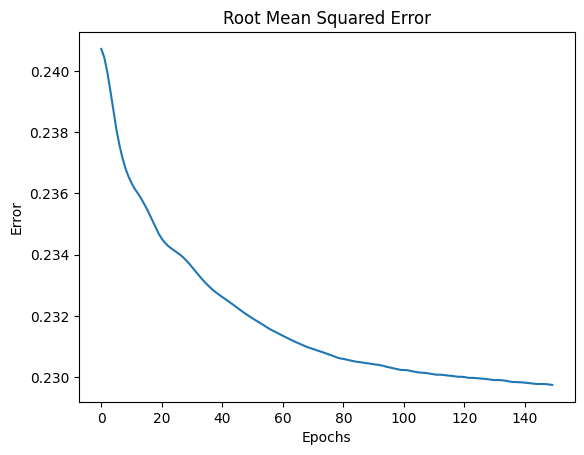

In [19]:
# Plot RMSE over epochs
plt.plot(history.history['root_mean_squared_error'])
plt.title('Root Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()

In [20]:
# Generate 12-month forecast
forecast_steps = 12
last_input = X_lagged[-1].reshape(1, -1)  # Start with the last input
predictions = []

for _ in range(forecast_steps):
    pred_scaled = tlnn.predict(last_input)  # Predict the next step
    pred = sc_y.inverse_transform(pred_scaled)[0, 0]  # Inverse transform the prediction
    predictions.append(pred)
    
    # Update input for the next prediction
    last_input = np.roll(last_input, -1)
    last_input[0, -1] = pred_scaled  # Add the new prediction to the input

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


C:\Users\brayk\AppData\Local\Temp\ipykernel_32836\2945854402.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_input[0, -1] = pred_scaled  # Add the new prediction to the input
C:\Users\brayk\AppData\Local\Temp\ipykernel_32836\2945854402.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_input[0, -1] = pred_scaled  # Add the new prediction to the input
C:\Users\brayk\AppData\Local\Temp\ipykernel_32836\2945854402.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

C:\Users\brayk\AppData\Local\Temp\ipykernel_32836\2945854402.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_input[0, -1] = pred_scaled  # Add the new prediction to the input
C:\Users\brayk\AppData\Local\Temp\ipykernel_32836\2945854402.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_input[0, -1] = pred_scaled  # Add the new prediction to the input
C:\Users\brayk\AppData\Local\Temp\ipykernel_32836\2945854402.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


C:\Users\brayk\AppData\Local\Temp\ipykernel_32836\2945854402.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_input[0, -1] = pred_scaled  # Add the new prediction to the input
C:\Users\brayk\AppData\Local\Temp\ipykernel_32836\2945854402.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_input[0, -1] = pred_scaled  # Add the new prediction to the input
C:\Users\brayk\AppData\Local\Temp\ipykernel_32836\2945854402.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


C:\Users\brayk\AppData\Local\Temp\ipykernel_32836\2945854402.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_input[0, -1] = pred_scaled  # Add the new prediction to the input


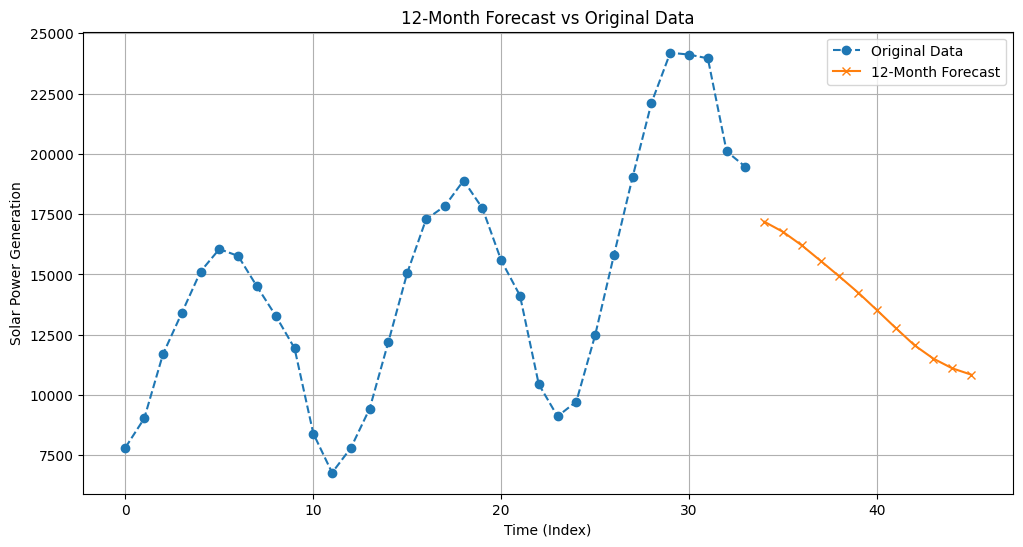

In [21]:
# Plot the original data and forecast
plt.figure(figsize=(12, 6))

# Plot original data
plt.plot(range(len(utility_gen_values)), utility_gen_values, label='Original Data', linestyle='--', marker='o')

# Plot predictions
forecast_range = range(len(utility_gen_values), len(utility_gen_values) + forecast_steps)
plt.plot(forecast_range, predictions, label='12-Month Forecast', linestyle='-', marker='x')

# Adding labels, legend, and title
plt.xlabel('Time (Index)')
plt.ylabel('Solar Power Generation')
plt.title('12-Month Forecast vs Original Data')
plt.legend()
plt.grid(True)
plt.show()

### Discussion
Unfortunately, the TLNN was unable to forecast the seasonality of solar data, leading to a general downwards trend, which we can deem will be inaccurate. Thus, the TLNN will be dropped from further testing